Device: cuda
Creating massive model...
Total Parameters: 60,166,026
Training samples: 5000
Parameters per training sample: 12033.2
Overparameterization ratio: 12033.2x

Training with weight decay = 0.0
WD=0e+00 | Epoch 1/30 | train_loss=0.529, train_acc=0.841, test_loss=0.220, test_acc=0.954, ||w||=51.7
WD=0e+00 | Epoch 3/30 | train_loss=0.022, train_acc=0.993, test_loss=0.057, test_acc=0.981, ||w||=51.7
WD=0e+00 | Epoch 6/30 | train_loss=0.002, train_acc=1.000, test_loss=0.054, test_acc=0.983, ||w||=51.8
WD=0e+00 | Epoch 9/30 | train_loss=0.000, train_acc=1.000, test_loss=0.052, test_acc=0.984, ||w||=51.8
WD=0e+00 | Epoch 12/30 | train_loss=0.000, train_acc=1.000, test_loss=0.053, test_acc=0.984, ||w||=51.8
WD=0e+00 | Epoch 15/30 | train_loss=0.000, train_acc=1.000, test_loss=0.053, test_acc=0.984, ||w||=51.8
WD=0e+00 | Epoch 18/30 | train_loss=0.000, train_acc=1.000, test_loss=0.053, test_acc=0.984, ||w||=51.8
WD=0e+00 | Epoch 21/30 | train_loss=0.000, train_acc=1.000, test_loss=0.05

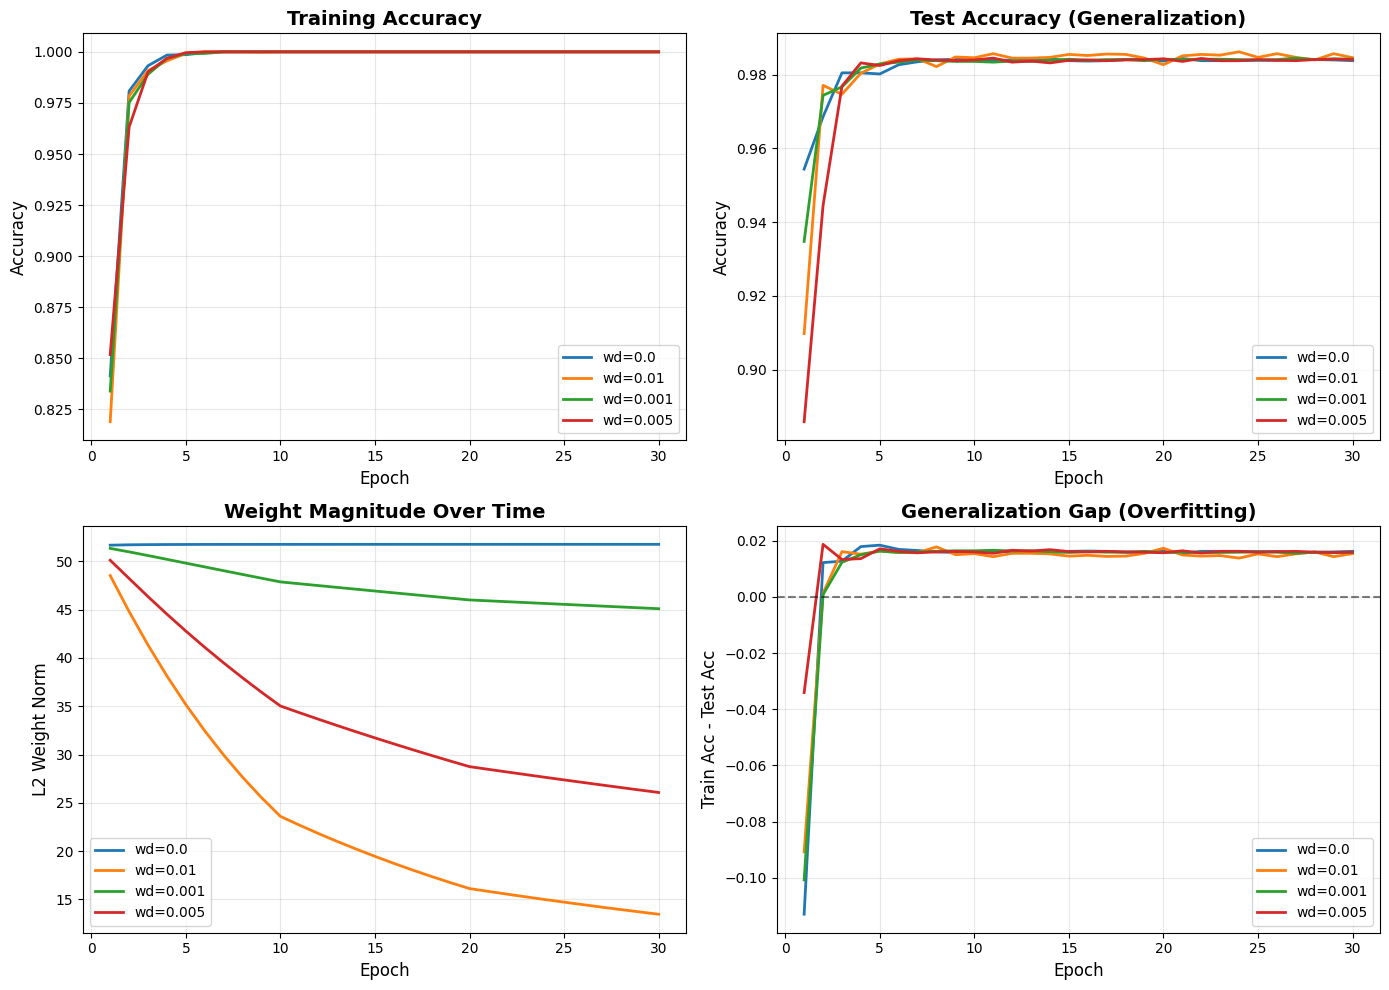


FINAL RESULTS SUMMARY

Weight Decay = 0.0
  Final Train Acc: 1.0000
  Final Test Acc:  0.9838
  Generalization Gap: 0.0162
  Final Weight Norm: 51.78

Weight Decay = 0.01
  Final Train Acc: 1.0000
  Final Test Acc:  0.9846
  Generalization Gap: 0.0154
  Final Weight Norm: 13.45

Weight Decay = 0.001
  Final Train Acc: 1.0000
  Final Test Acc:  0.9842
  Generalization Gap: 0.0158
  Final Weight Norm: 45.11

Weight Decay = 0.005
  Final Train Acc: 1.0000
  Final Test Acc:  0.9841
  Generalization Gap: 0.0159
  Final Weight Norm: 26.07


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import math
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.ToTensor()

train_full = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root='.', train=False, download=True, transform=transform)


num_train_small = 5000  # Small dataset for fast training
small_train = Subset(train_full, range(num_train_small))

train_loader = DataLoader(small_train, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)


class MassiveCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # 1x28x28 → 64x28x28
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # 64x28x28 → 128x28x28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),      # 128x14x14

            # 128x14x14 → 256x14x14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),      # 256x7x7
        )

        # 256 * 7 * 7 = 12544 features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def l2_weight_norm(model):
    total = 0.0
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                total += torch.sum(p ** 2).item()
    return math.sqrt(total)


print("Creating massive model...")
model_test = MassiveCNN().to(device)
num_params = count_params(model_test)
print(f"Total Parameters: {num_params:,}")
print(f"Training samples: {num_train_small}")
print(f"Parameters per training sample: {num_params / num_train_small:.1f}")
print(f"Overparameterization ratio: {num_params / num_train_small:.1f}x")
del model_test


criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, optimizer, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            running_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total


def run_experiment(weight_decay, epochs=30):
    model = MassiveCNN().to(device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.02,  # Slightly higher LR for faster convergence
        momentum=0.9,
        weight_decay=weight_decay
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "weight_norm": [],
    }

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader)
        te_loss, te_acc = evaluate(model, test_loader)
        wnorm = l2_weight_norm(model)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)
        history["weight_norm"].append(wnorm)

        if (epoch + 1) % 3 == 0 or epoch == 0:
            print(
                f"WD={weight_decay:.0e} | "
                f"Epoch {epoch+1}/{epochs} | "
                f"train_loss={tr_loss:.3f}, train_acc={tr_acc:.3f}, "
                f"test_loss={te_loss:.3f}, test_acc={te_acc:.3f}, "
                f"||w||={wnorm:.1f}"
            )

        scheduler.step()

    return model, history


weight_decays = [0.0,1e-2, 1e-3, 5e-3]
results = {}

for wd in weight_decays:
    print(f"\n{'='*60}")
    print(f"Training with weight decay = {wd}")
    print('='*60)
    model, history = run_experiment(weight_decay=wd, epochs=30)
    results[wd] = history


epochs = range(1, len(results[0.0]["train_loss"]) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for wd in weight_decays:
    axes[0, 0].plot(epochs, results[wd]["train_acc"], label=f"wd={wd}", linewidth=2)
axes[0, 0].set_xlabel("Epoch", fontsize=12)
axes[0, 0].set_ylabel("Accuracy", fontsize=12)
axes[0, 0].set_title("Training Accuracy", fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

for wd in weight_decays:
    axes[0, 1].plot(epochs, results[wd]["test_acc"], label=f"wd={wd}", linewidth=2)
axes[0, 1].set_xlabel("Epoch", fontsize=12)
axes[0, 1].set_ylabel("Accuracy", fontsize=12)
axes[0, 1].set_title("Test Accuracy (Generalization)", fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

for wd in weight_decays:
    axes[1, 0].plot(epochs, results[wd]["weight_norm"], label=f"wd={wd}", linewidth=2)
axes[1, 0].set_xlabel("Epoch", fontsize=12)
axes[1, 0].set_ylabel("L2 Weight Norm", fontsize=12)
axes[1, 0].set_title("Weight Magnitude Over Time", fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


for wd in weight_decays:
    gap = [train - test for train, test in zip(results[wd]["train_acc"], results[wd]["test_acc"])]
    axes[1, 1].plot(epochs, gap, label=f"wd={wd}", linewidth=2)
axes[1, 1].set_xlabel("Epoch", fontsize=12)
axes[1, 1].set_ylabel("Train Acc - Test Acc", fontsize=12)
axes[1, 1].set_title("Generalization Gap (Overfitting)", fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
for wd in weight_decays:
    final_train = results[wd]["train_acc"][-1]
    final_test = results[wd]["test_acc"][-1]
    final_norm = results[wd]["weight_norm"][-1]
    gap = final_train - final_test
    print(f"\nWeight Decay = {wd}")
    print(f"  Final Train Acc: {final_train:.4f}")
    print(f"  Final Test Acc:  {final_test:.4f}")
    print(f"  Generalization Gap: {gap:.4f}")
    print(f"  Final Weight Norm: {final_norm:.2f}")